In [1]:
import os
import sys
import time
import torch
import random
import scipy.io
import numpy as np
from pyDOE import lhs
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from collections import OrderedDict

mpl.rcParams.update(mpl.rcParamsDefault)
np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['figure.max_open_warning'] = 4

## Global functions

In [2]:
if torch.cuda.is_available():
    """ Cuda support """
    print('cuda available')
    device = torch.device('cuda')
else:
    print('cuda not avail')
    device = torch.device('cpu')

def seed_torch(seed):
    """ Seed initialization """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
seed_torch(2341)
torch.cuda.empty_cache()

def tonp(tensor):
    """ Torch to Numpy """
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    elif isinstance(tensor, np.ndarray):
        return tensor
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or '\
            'np.ndarray, but got {}'.format(type(input)))

def grad(u, x):
    """ Get grad """
    gradient = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    return gradient

cuda available


## Initializations

In [3]:
file_path = './'
file_name = 'losses.txt'

data = scipy.io.loadmat(file_path + 'AC.mat')
Exact = data['uu']
Exact0 = np.real(Exact)
t0 = data['tt'].flatten()[:,None]
x0 = data['x'].flatten()[:,None]
lbc = torch.tensor([x0.min(), t0.min()]).to(torch.float32).to(device)
ubc = torch.tensor([x0.max(), t0.max()]).to(torch.float32).to(device)

xdim, tdim = 4.0, 1.0

nx, nt = (1001, 1001)
x = np.linspace(-1, 1, nx)
t = np.linspace(-1, 1, nt)
x0, t0 = np.meshgrid(x, t)
Exact0 = np.sin(xdim*np.pi*x0)*np.sin(tdim*np.pi*t0)
Exact0 = Exact0.T
x0, t0 = x[:,None], t[:,None]
lbc = torch.tensor([x0.min(), t0.min()]).to(torch.float32).to(device)
ubc = torch.tensor([x0.max(), t0.max()]).to(torch.float32).to(device)

## DNN

In [4]:


class DNN(torch.nn.Module):
    """ DNN Class """
    
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.depth = len(layers) - 1
        self.activation = torch.nn.Tanh
        
        # Layers
        layer_list = list()
        for i in range(self.depth - 1):
            w_layer = torch.nn.Linear(layers[i], layers[i+1], bias=True)
            torch.nn.init.xavier_normal_(w_layer.weight)
            layer_list.append(('layer_%d' % i, w_layer))
            layer_list.append(('activation_%d' % i, self.activation()))

        w_layer = torch.nn.Linear(layers[-2], layers[-1], bias=True)
        torch.nn.init.xavier_normal_(w_layer.weight)
        layer_list.append(('layer_%d' % (self.depth - 1), w_layer))
        layerDict = OrderedDict(layer_list)
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

## PINN

In [5]:
class PINN():
    """ PINN Class """
    
    def __init__(self, X_u, u, X_r, lb, ub, dimx, dimt, savept=None):
        
        # Initialization
        self.rba = 1  # RBA weights
        self.sa = 0   # SA weights
        self.iter = 0
        self.exec_time = 0
        self.print_step = 100
        self.savept = savept
        self.dimx, self.dimt = dimx, dimt
        self.dimx_, self.dimt_ = nx, nt  # solution dim
        self.first_opt = 20000
        self.freeze = self.first_opt
        self.it, self.l2, self.linf = [], [], []
        self.loss, self.losses = None, []
        self.opt = 1

        # Intermediate results
        self.Exact = Exact0
        X, T = np.meshgrid(x0, t0)
        X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
        self.xx = torch.tensor(X_star[:, 0:1]).float().to(device)
        self.tt = torch.tensor(X_star[:, 1:2]).float().to(device)
        
        # Data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_r = torch.tensor(X_r[:, 0:1], requires_grad=True).float().to(device)
        self.t_r = torch.tensor(X_r[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.ub = self.u[self.dimx:]
        self.u = self.u[:self.dimx]
        self.N_r = tonp(self.x_r).size
        self.N_u = tonp(self.u).size
        self.dnn = DNN(layers).to(device)
        
        # RBA initialization
        if self.rba == 1:
            self.rsum = 0
            self.eta = 0.001
            self.gamma = 0.999
            self.init = 1  # initialization mode (1 or 2)
            
        # SA weights initialization
        if self.sa == 1:
            self.lamr = torch.rand(self.N_r, 1, requires_grad=True).float().to(device)*1
            self.lamu = torch.rand(self.N_u, 1, requires_grad=True).float().to(device)*1
            self.lamr = torch.nn.Parameter(self.lamr)
            self.lamu = torch.nn.Parameter(self.lamu)
            # Optimizer2 (SA weights)
            self.optimizer2 = torch.optim.Adam([self.lamr] + [self.lamu], lr=0.005, maximize=True)
            
        # Optimizer (1st ord)
        self.optimizer = torch.optim.Adam(self.dnn.parameters(), lr=1e-3, betas=(0.9, 0.999))
        self.scheduler = lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9, verbose=True)
        self.step_size = 5000

    def net_u(self, x, t):
        """ Get the velocities """
        
        u = self.dnn(torch.cat([x, t], dim=1))
        return u

    def net_r(self, x, t):
        """ Get the residuals """
        
        u = self.net_u(x, t)
        u_t = grad(u, t)
        u_tt = grad(u_t, t)
        u_x = grad(u, x)
        u_xx = grad(u_x, x)
        a1 = xdim
        a2 = tdim
        ksq = 1.0
        force = - (a1*np.pi)**2*torch.sin(a1*np.pi*x)*torch.sin(a2*np.pi*t) - \
                    (a2*np.pi)**2*torch.sin(a1*np.pi*x)*torch.sin(a2*np.pi*t) + \
                    ksq*torch.sin(a1*np.pi*x)*torch.sin(a2*np.pi*t)
        f = u_xx + u_tt + ksq*u - force
        return f, u_x

    def loss_func(self):
        """ Loss function """
        
        self.optimizer.zero_grad()
        if self.sa == 1:
            self.optimizer2.zero_grad()

        # Predictions
        self.u_pred = self.net_u(self.x_u, self.t_u)
        self.r_pred, u_x_pred = self.net_r(self.x_r, self.t_r)

        if self.rba == True:
            eta = 1 if self.init == 2 and self.iter == 0 else self.eta
            r_norm = eta*torch.abs(self.r_pred)/torch.max(torch.abs(self.r_pred))
            self.rsum = (self.rsum*self.gamma + r_norm).detach()
            loss_r = torch.mean((self.rsum*self.r_pred)**2)
            loss_u = torch.mean((self.u_pred - self.u)**2)
            
        elif self.sa == True and self.iter < self.freeze:
            loss_r = torch.mean((self.lamr*self.r_pred)**2)
            loss_u = torch.mean((self.lamu*(self.u_pred - self.u))**2)

        else:
            loss_r = torch.mean(self.r_pred**2)
            loss_u = torch.mean((self.u_pred - self.u)**2)

        # Loss calculation
        self.loss = loss_r + loss_u
        self.loss.backward()
        self.iter += 1

        if self.iter % self.print_step == 0:
            
            with torch.no_grad():
                # Grid prediction (for relative L2)
                res = self.net_u(self.xx, self.tt)
                sol = tonp(res)
                sol = np.reshape(sol, (self.dimt_, self.dimx_)).T

                # L2 calculation
                l2_rel = np.linalg.norm(self.Exact.flatten() - sol.flatten(), 2) / np.linalg.norm(self.Exact.flatten(), 2)
                l_inf = np.linalg.norm(self.Exact.flatten() - sol.flatten(), np.inf) / np.linalg.norm(self.Exact.flatten(), np.inf)
                print('Iter %d, Loss: %.3e, Rel_L2: %.3e, L_inf: %.3e, t/iter: %.1e' % 
                     (self.iter, self.loss.item(), l2_rel, l_inf, self.exec_time))
                print()
                
                self.it.append(self.iter)
                self.l2.append(l2_rel)
                self.linf.append(l_inf)
            
        # Optimizer properties
        if self.opt == 1:
            self.optimizer.step()
            if self.sa == True:
                self.optimizer2.step()
        elif self.opt == 2:
            return self.loss
                
    def train(self):
        """ Train model """
        
        self.dnn.train()
        for epoch in range(self.first_opt):
            start_time = time.time()
            self.loss_func()
            end_time = time.time()
            self.exec_time = end_time - start_time
            if (epoch+1) % self.step_size == 0:
                self.scheduler.step()
                
        self.opt = 2
        print('LBFGS switch')

        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=0.8,
            max_iter=100,
            # max_eval=50000,
            # history_size=50,
            tolerance_grad=1.e-5,
            tolerance_change=1.e-9,
            # line_search_fn="strong_wolfe"
        )
        for epoch in range(20):
            self.optimizer.step(self.loss_func)

        # Write data
        a = np.array(self.it)
        b = np.array(self.l2)
        c = np.array(self.linf)
        # Stack them into a 2D array.
        d = np.column_stack((a, b, c))
        file = open(file_path + file_name, "w+")
        file.close()
        file = open(file_path + file_name, "w+")
        file.close()
        # Write to a txt file
        np.savetxt('losses.txt', d, fmt='%.10f %.10f %.10f')

        if self.savept != None:
            torch.save(self.dnn.state_dict(), str(self.savept)+".pt")
    
    def predict(self, X):
        x = torch.tensor(X[:, 0:1]).float().to(device)
        t = torch.tensor(X[:, 1:2]).float().to(device)
        self.dnn.eval()
        u = self.net_u(x, t)
        u = tonp(u)
        return u

## Data generation

X_r shape: (25600, 2)
X_u shape: (200, 2)
u shape: (200, 1)


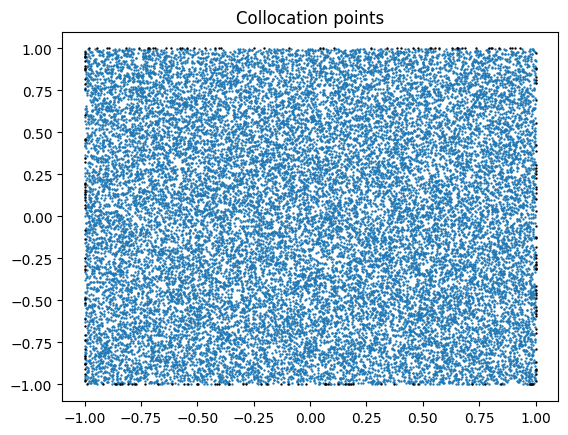

In [6]:
# Collocation points
dimx = nx
dimt = nt
N_u = 50
N_r = 25600
hidden = 128
layers = [2] + [hidden]*6 + [1]

# Definition
Exact = Exact0.T
tm = np.linspace(t0.min(), t0.max(), dimt)[:, None]
xm = np.linspace(x0.min(), x0.max(), dimx)[:, None]
X, T = np.meshgrid(xm, tm)

# Doman bounds
lb = tonp(lbc)
ub = tonp(ubc)
xx1 = np.hstack((x0*0-1, t0))
uu1 = np.zeros_like(x0)

# Top/bot boundaries
xx2 = np.hstack((x0, t0*0+1))
xx3 = np.hstack((x0, t0*0-1))
xx4 = np.hstack((x0*0+1, t0))
uu2 = uu1
uu3 = uu1
uu4 = uu1

# Random choice
idx0 = np.random.choice(dimt, N_u, replace=False)
idx = np.random.choice(dimt, N_u, replace=False)
idx2 = np.random.choice(dimt, N_u, replace=False)
idx3 = np.random.choice(dimt, N_u, replace=False)
                 
u_train = np.vstack([uu1[idx0, :], uu2[idx, :], uu3[idx2, :], uu4[idx3, :]])
X_u_train = np.vstack([xx1[idx0, :], xx2[idx, :], xx3[idx2, :], xx4[idx3, :]])

# Collocation points
X_r_train = lb + (ub-lb)*lhs(2, N_r)

print('X_r shape:', X_r_train.shape)
print('X_u shape:', X_u_train.shape)
print('u shape:', u_train.shape)
            
plt.figure(1)
plt.title('Collocation points')
plt.scatter(X_r_train[:, 1], X_r_train[:, 0], s=0.5)
plt.scatter(X_u_train[:, 1], X_u_train[:, 0], s=0.5, c='k')
plt.show()

In [7]:
model = PINN(X_u_train, u_train, X_r_train, lb, ub, dimx, dimt=N_u, savept='weights')

Adjusting learning rate of group 0 to 1.0000e-03.


## Training

In [8]:
%%time
model.train() # RBA

Iter 100, Loss: 3.539e+01, Rel_L2: 9.966e-01, L_inf: 9.966e-01, t/iter: 2.6e-02

Iter 200, Loss: 6.359e+01, Rel_L2: 2.439e+00, L_inf: 2.439e+00, t/iter: 2.4e-02

Iter 300, Loss: 2.632e+01, Rel_L2: 2.657e+00, L_inf: 2.657e+00, t/iter: 2.4e-02

Iter 400, Loss: 2.309e+00, Rel_L2: 2.074e+00, L_inf: 2.074e+00, t/iter: 2.5e-02

Iter 500, Loss: 2.039e-01, Rel_L2: 8.267e-01, L_inf: 8.267e-01, t/iter: 2.4e-02

Iter 600, Loss: 7.326e-02, Rel_L2: 1.624e-01, L_inf: 1.624e-01, t/iter: 2.5e-02

Iter 700, Loss: 9.518e-02, Rel_L2: 1.418e-01, L_inf: 1.418e-01, t/iter: 2.4e-02

Iter 800, Loss: 1.452e+00, Rel_L2: 1.738e-01, L_inf: 1.738e-01, t/iter: 2.4e-02

Iter 900, Loss: 4.939e-02, Rel_L2: 1.093e-01, L_inf: 1.093e-01, t/iter: 2.4e-02

Iter 1000, Loss: 1.753e-01, Rel_L2: 1.073e-01, L_inf: 1.073e-01, t/iter: 2.4e-02

Iter 1100, Loss: 2.426e-01, Rel_L2: 1.093e-01, L_inf: 1.093e-01, t/iter: 2.4e-02

Iter 1200, Loss: 4.247e-02, Rel_L2: 9.134e-02, L_inf: 9.134e-02, t/iter: 2.5e-02

Iter 1300, Loss: 3.667e-0

In [15]:
%%time
model.train() # SA

Iter 100, Loss: 5.125e+03, Rel_L2: 4.735e+00, L_inf: 4.735e+00, t/iter: 2.5e-02

Iter 200, Loss: 8.937e+03, Rel_L2: 2.631e+00, L_inf: 2.631e+00, t/iter: 2.5e-02

Iter 300, Loss: 3.779e+03, Rel_L2: 4.358e+00, L_inf: 4.358e+00, t/iter: 2.5e-02

Iter 400, Loss: 1.625e+02, Rel_L2: 4.998e+00, L_inf: 4.998e+00, t/iter: 2.5e-02

Iter 500, Loss: 5.311e+01, Rel_L2: 2.087e+00, L_inf: 2.087e+00, t/iter: 2.5e-02

Iter 600, Loss: 3.943e+02, Rel_L2: 1.225e+00, L_inf: 1.225e+00, t/iter: 2.5e-02

Iter 700, Loss: 1.429e+02, Rel_L2: 9.233e-01, L_inf: 9.233e-01, t/iter: 2.5e-02

Iter 800, Loss: 2.794e+01, Rel_L2: 7.624e-01, L_inf: 7.624e-01, t/iter: 2.5e-02

Iter 900, Loss: 8.294e+02, Rel_L2: 6.922e-01, L_inf: 6.922e-01, t/iter: 2.5e-02

Iter 1000, Loss: 2.728e+02, Rel_L2: 6.631e-01, L_inf: 6.631e-01, t/iter: 2.5e-02

Iter 1100, Loss: 9.536e+02, Rel_L2: 6.383e-01, L_inf: 6.383e-01, t/iter: 2.5e-02

Iter 1200, Loss: 2.032e+02, Rel_L2: 6.216e-01, L_inf: 6.216e-01, t/iter: 2.5e-02

Iter 1300, Loss: 6.972e+0

In [8]:
%%time
model.train() # Vanilla

Iter 100, Loss: 4.399e+03, Rel_L2: 3.691e+00, L_inf: 3.691e+00, t/iter: 2.5e-02

Iter 200, Loss: 2.809e+03, Rel_L2: 2.351e+00, L_inf: 2.351e+00, t/iter: 2.5e-02

Iter 300, Loss: 1.422e+03, Rel_L2: 1.570e+00, L_inf: 1.570e+00, t/iter: 2.5e-02

Iter 400, Loss: 4.874e+02, Rel_L2: 3.628e+00, L_inf: 3.628e+00, t/iter: 2.5e-02

Iter 500, Loss: 8.980e+01, Rel_L2: 2.771e+00, L_inf: 2.771e+00, t/iter: 2.5e-02

Iter 600, Loss: 4.517e+01, Rel_L2: 2.062e+00, L_inf: 2.062e+00, t/iter: 2.5e-02

Iter 700, Loss: 7.675e+00, Rel_L2: 1.651e+00, L_inf: 1.651e+00, t/iter: 2.5e-02

Iter 800, Loss: 3.633e+00, Rel_L2: 1.346e+00, L_inf: 1.346e+00, t/iter: 2.5e-02

Iter 900, Loss: 1.159e+01, Rel_L2: 1.151e+00, L_inf: 1.151e+00, t/iter: 2.5e-02

Iter 1000, Loss: 3.574e+01, Rel_L2: 1.016e+00, L_inf: 1.016e+00, t/iter: 2.5e-02

Iter 1100, Loss: 1.713e+01, Rel_L2: 9.161e-01, L_inf: 9.161e-01, t/iter: 2.5e-02

Iter 1200, Loss: 1.091e+01, Rel_L2: 8.547e-01, L_inf: 8.547e-01, t/iter: 2.5e-02

Iter 1300, Loss: 7.224e+0

L2: 0.003411080459538149


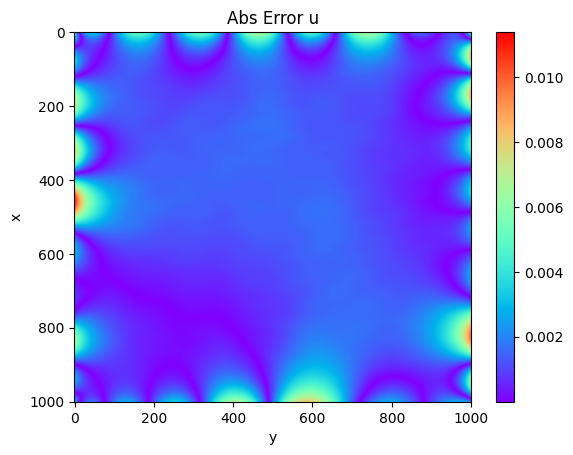

In [10]:
# Prediction
Exact = Exact0
X, T = np.meshgrid(x0, t0)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_pred = model.predict(X_star)
U_pred = np.reshape(u_pred, (Exact.shape[1], Exact.shape[0])).T
l2_rel = np.linalg.norm(Exact.flatten() - U_pred.flatten(), 2) / np.linalg.norm(Exact.flatten(), 2)
print('L2:', l2_rel)

plt.figure(1)
plt.title('Abs Error u')
plt.xlabel('y')
plt.ylabel('x') 
plt.imshow(np.abs(Exact-U_pred), aspect='auto', cmap='rainbow')
plt.colorbar()
plt.show()